# Introduction

L'objectif de ce notebook est de tester des modèles d'ensemble qui permettent de fusionner les prédictions des meilleurs modèles qu'on pu trouver au cours de nos tests de modélisations sur les textes et les images.

On tester un modèle classique de fusion qui reprend les principe de la classe **sklearn.ensemble.VotingClassifier** à laquelle on aurait passer le paramètre **voting = "soft"**.

# Initialisation

In [1]:
import sys
import os

if 'google.colab' in sys.modules:
    from google.colab import drive
    if not os.path.exists('/content/drive'):
      drive.mount('/content/drive/')
    %cd drive/MyDrive/nov23_bds_rakuten
else:
    root_files = os.listdir()
    if not "requirements.txt" in root_files:
        print("The jupyter server root should be set to root of git project")
        print("If you're on vscode add the following to your settings.json file")
        print('"jupyter.notebookFileRoot": "${workspaceFolder}"')

Mounted at /content/drive/
/content/drive/MyDrive/nov23_bds_rakuten


In [2]:
random_state = 42
output_dir = "output/data-modeling-fusion"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pathlib import Path
import re
from tqdm import tqdm
import pickle as pickle

import zipfile

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback,EarlyStopping, LearningRateScheduler
from tensorflow.keras import backend as K
import keras.saving

from keras.utils import to_categorical
from keras.models import load_model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.svm import SVC

from joblib import dump, load


# Librairie de fonctions

On récupère ici les fonctions définies dans le notebook **data-modeling-images-1**.

Bien que je préfère en général définir les fonctions au fur et à mesure de leur utilisation, la multiplication des stratégies que nous allons tester rend plus simple de les rassembler dans cette section. En les extrayant du déroulement de chaque stratégie, nous pourrons plus efficacement dupliquer et identifier leur trame commune.

## Import des données


Commençons par définir une fonction **import_images** qui permet d'importer le jeu d'images que l'on souhaite utiliser.

In [4]:
def import_images(zip_path,dest_dir):
    image_path = dest_dir
    image_dir = Path(image_path)
    if image_dir.exists():
        print("images already imported from drive")
    else:
        print("extracting images from drive into colab's session storage... (about 1 min)")
        with zipfile.ZipFile(zip_path,"r") as images_zip:
            images_zip.extractall(image_path)
    image_path = image_path + "/images"
    return image_path

## Rapport de modèle

Avant de commencer à créer notre modèle, nous allons nous occuper de comment on pourra comparer les différentes stratégies que nous allons tester.

Nous allons créer un dataframe **df_reporting** qui contiendra les informations pertinentes sur notre stratégie de modélisation ainsi que ses résultats:
* Un nom et un id de modèle
* Les sources de données utilisées ainsi que la taille du subset de données.
* Les hyper-paramètres du modèle
* Les métriques de performance des tests.

Au fur et à mesure de nos tests, on veillera à sauvegarder ce dataframe dans un fichier **model_reporting.csv**. Ce fichier nous assurera qu'on puisse reprendre nos tests là où ils se sont arrêtés en cas d'interruption.



Ajoutons une fonction qui va créer le dataframe **df_reporting** en y ajoutant un modèle d'exemple.


In [6]:
def create_reporting_df(save=True):
  reporting_df = pd.DataFrame([{
      #model infos
      "model_id":int(0),
      "model_name":"Example model",

      #data sources
      "dataset_source": "output/data-exploration/X_train_pre.csv",
      "dataset_resampled": False,
      "image_dataset_source" : "data/images.zip",
      "image_dataset_zoomed" : False,
      "test_size": int(42458),

      # models selected
      "image_model_name": "Model 3.4.3",
      "image_model_id": "343",
      "image_model_path": "output/data-modeling-images-3/model-331.keras",
      "text_model_name": "Model 1.10",
      "text_model_id": "110",
      "text_model_path": "output/data-modeling-text-1bis/model_10_svm.joblib",

      # fusion model
      "fusion_model": "VotingClassifier(voting='soft')",

      #hyper parameters
      "image_model_weight": 0.5,
      "text_model_weight": 0.5,

      #metrics (on on test)
      "test_f1_score": 0.42,
      "test_accuracy": 0.57,

      #other
      "remarks": "Ceci n'est pas un vrai modèle. C'est juste un exemple",
  }])

  reporting_df.set_index("model_id",inplace=True)
  if save:
    reporting_df.to_csv(output_dir+"/model_reporting.csv")
  return reporting_df




Ajoutons également une fonction qui va nous permettre de charger un **model_reporting_df** s'il existe.


In [7]:
def load_reporting_df():
  return pd.read_csv(output_dir+"/model_reporting.csv",index_col="model_id")

On a besoin d'une fonction pour ajouter une nouvelle ligne dans **reporting_df**.

In [8]:
def add_reporting_line(model_id:int,model_name:str,save:bool=True):
  reporting_df.loc[int(model_id),"model_name"] = str(model_name)
  if save:
    reporting_df.to_csv(output_dir+"/model_reporting.csv")

Ajoutons une fonction pour ajouter ou modifier des informations dans notre modèle. On veillera à ce que cette fonction sauvegarde automatiquement le dataframe dans **model_reporting.csv**. On a besoin de garder le maximum d'informations en cas d'interruption.

In [9]:
def update_reporting_line(model_id: int,d:dict={},save:bool=True):
  for key in d.keys():
        reporting_df.at[int(model_id), str(key)] = d.get(key)
  if save:
    reporting_df.to_csv(output_dir+"/model_reporting.csv")

Ajoutons une fonction **get_reporting_value** qui permette de récupérer une information stockée pour un modèle.

In [10]:
def get_reporting_value(model_id,key,default=None):
  try:
    value = reporting_df.at[model_id,key]
    if np.isnan(value):
      value=None
  except KeyError:
    value=None

  if value == None and default != None:
      value=default
  return value

## Création du modèle

Nous allons également avoir besoin d'une métrique personnalisée **w_f1_score** qui permette de calculer le F1 Score pondéré. On veille à ajouter l'annotation **@keras.saving.register_keras_serializable** pour que Keras ne pose pas de problème lors du chargement du modèle.


In [11]:
def f1_score_sklearn(y_true, y_pred):
    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    return f1_score(y_true_classes, y_pred_classes, average='weighted')

@keras.saving.register_keras_serializable(name='w_f1_score')
def w_f1_score(y_true, y_pred):
    f1 = tf.py_function(f1_score_sklearn, (y_true, y_pred), tf.float64)
    return f1

## Sauvegarde du modèle

Toujours en vue d'être résilient par rapport aux interruptions qui ont lieu régulièrement lors de la phase d'entraînement du modèle, créons des fonctions qui vont nous permettre de sauvegarder et restaurer un modèle Keras, afin de pouvoir reprendre l'entraînement s'il a été stoppé, ou même d'afficher les métriques d'un modèle dont l'entraînement est complet.


In [12]:
def load_saved_model(model_dir,model_id):
  model_path = model_dir+("/model-%d.keras" % model_id)
  model_path_obj = Path(model_path)
  if model_path_obj.exists():
    print("Load previous model from",model_path)
    return load_model(model_path)
  else:
    print("No previous model found at",model_path)
    return None

## Évaluation du modèle

Ajoutons quelques fonctions qui vont nous faciliter l'affichage de graphiques et de matrices lors de la phase d'évaluation du modèle.


Ici, on récupère du notebook **data-exploration** les labels correspondant aux classes, pour donner plus de lisibilité lors de l'évaluation.


In [13]:
prdcodetype2label = {
    10 : "Livre occasion",
    40 : "Jeu vidéo, accessoire tech",
    50 : "Accessoire Console",
    60 : "Console de jeu",
    1140 : "Figurine",
    1160 : "Carte Collection",
    1180 : "Jeu Plateau",
    1280 : "Jouet enfant,déguisement",
    1281 : "Jeu société",
    1300 : "Jouet tech",
    1301 : "Jeu intérieur,chaussettes",
    1302 : "Jeu extérieur,vêtement",
    1320 : "Bébé",
    1560 : "Mobilier intérieur",
    1920 : "Chambre",
    1940 : "Cuisine",
    2060 : "Décoration intérieure",
    2220 : "Animal",
    2280 : "Revues,journaux",
    2403 : "Magazines,livres,BDs",
    2462 : "Jeu occasion",
    2522 : "Bureautique,papeterie",
    2582 : "Mobilier extérieur",
    2583 : "Piscine",
    2585 : "Bricolage",
    2705 : "Livre neuf",
    2905 : "Jeu PC",
}

Enfin, ajoutons une fonction **plot_confusion_matrix** qui nous permette d'afficher la matrice de confusion de manière lisible.


In [14]:
def plot_confusion_matrix(cm):
  plt.figure(figsize=(15, 8))
  sns.set(font_scale=0.8)
  classes = [(str(c) +": "+ prdcodetype2label[int(c)]) for c in classes_ordered]
  sns.heatmap(cm, annot=True, cbar=True, square=False,fmt='g'
              ,xticklabels=classes,yticklabels=classes)
  plt.xlabel('Prédit')
  plt.ylabel('Réel')
  plt.title('Matrice de confusion')
  plt.show()

Ajoutons une fonction qui va nous permettre de réordonner les colonnes de la matrice de prédiction retournée par **model.predict** pour un modèle keras selon le nouvel ordre passé

In [15]:
def reorder_predict_cols(pred,old_ordered_classes,new_ordered_classes):
  old_classes_to_index = {}
  for i in range(len(old_ordered_classes)):
    old_classes_to_index[old_ordered_classes[i]] = i

  reordered_indexes = [old_classes_to_index[c] for c in new_ordered_classes]
  reordered_pred = pred[:, reordered_indexes]
  return reordered_pred


Créons une fonction **get_average_pred** qui combine les predictions du modèle d'image et du modèle de text en calculant la prediction moyenne des deux.

In [16]:
def get_average_pred(img_pred,text_pred,img_pred_weight=0.5,text_pred_weight=0.5):
  combined_pred = (img_pred * img_pred_weight) + (text_pred * text_pred_weight)
  final_pred = np.argmax(combined_pred, axis=1)
  return final_pred

# Modélisation 1.1

Comme annoncé dans l'introduction, pour ce premier test de fusion de nos modèles texte et image, nous allons utiliser une approche probabiliste qui réplique l'algorithme employés par la classe **sklearn.ensemble.VotingClassifier** à laquelle on aurait passer le paramètre **voting = "soft"**.

On aurait pu simplement utiliser cette classe, malheuresement, elle n'est pas compatible avec les modèles keras. Sachant qu'il s'agit simplement de faire une moyenne des probabilités des prédictions en sortie des deux modèles, il ne paraît pas compliqué de ré-implémenter nous même son comportement.

In [17]:
model_id = 411

## Initialisation du rapport de modèle

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.


In [18]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


output/data-modeling-fusion/model_reporting.csv not found. creating one


In [19]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,test_size,image_model_name,image_model_id,image_model_path,text_model_name,text_model_id,text_model_path,fusion_model,image_model_weight,text_model_weight,test_f1_score,test_accuracy,remarks
model_id,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458,Model 3.4.3,343,output/data-modeling-images-3/model-331.keras,Model 1.10,110,output/data-modeling-text-1bis/model_10_svm.jo...,VotingClassifier(voting='soft'),0.5,0.5,0.42,0.57,Ceci n'est pas un vrai modèle. C'est juste un ...


Ajoutons une ligne correspondant à notre modèle


In [20]:
add_reporting_line(model_id,"Modèle 4.1.1")

## Import des données

On importe les images zoomées qui ont été produites par le notebook **data_preprocessing_images**

In [21]:
image_path = import_images("output/data-preprocessing-images/images_pre.zip","/tmp/rakuten-images-2")

extracting images from drive into colab's session storage... (about 1 min)


On charge maintenant le csv des données en sortie du notebook **Data-preprocessing-text-stopWord-Steming** qui a lui même utilisé la sortie du notebook **data_preprocessing_resampling**.

Nous n'aurons pas besoin de refaire le split des données d'entrainement, **data_preprocessing_resampling** s'en étant déjà chargé. Nous avons juste à charger les datasets d'entrainement et de test:
- **X_train_trad.csv**: L'ensemble d'entrainement
- **X_test_trad.csv**: L'ensemble de test

In [22]:
df_train = pd.read_csv("output/data-preprocessing-text-stopWord-steming/X_train_trad.csv",index_col=0)

df_test = pd.read_csv("output/data-preprocessing-text-stopWord-steming/X_test_trad.csv",index_col=0)
df_test.head()

,productid,imageid,text,lang,imagefile,prdtypecode,text_fr
index,,,,,,,
29927,3469563513,1215209457,Adventure Parks Heavy Duty Tree Strap - Dont t...,en,1280/image_1215209457_product_3469563513.jpg,1280,attachez pouvez faire correctement balançoire ...
42596,4152889175,1309607798,Magideal 2 Pcs Orff Instrument De Musique Hoch...,fr,1320/image_1309607798_product_4152889175.jpg,1320,enfants cm stimuler développant orff accessoir...
158,1190507078,1068211845,Casa Padrino Baroque Dining Room With Armrests...,en,1560/image_1068211845_product_1190507078.jpg,1560,pouvez cm produit original hauteur motif noir ...
20061,4236041996,1324088536,T6 Xml Zoomable Led Lampe De Poche Tactique + ...,fr,1302/image_1324088536_product_4236041996.jpg,1302,clickyswitch emitter type tactique 18650mode x...
20931,3836739131,1250952042,Organisateur Enfants En Bois Keepsake Cadeau P...,fr,1280/image_1250952042_product_3836739131.jpg,1280,stockage temp non séparée venir placez morceau...


On peut déjà renseigner les informations sur les données sources qu'on utilise.


In [23]:

update_reporting_line(model_id,{
    "dataset_source": "output/data-preprocessing-text-stopWord-steming/X_test_trad.csv",
    "dataset_resampled": True,
    "image_dataset_source" : "output/data-preprocessing-images/images_pre.zip",
    "image_dataset_zoomed" : True,
})

## Preprocessing

In [24]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8492 entries, 29927 to 18545
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   productid    8492 non-null   int64 
 1   imageid      8492 non-null   int64 
 2   text         8492 non-null   object
 3   lang         8492 non-null   object
 4   imagefile    8492 non-null   object
 5   prdtypecode  8492 non-null   int64 
 6   text_fr      8491 non-null   object
dtypes: int64(3), object(4)
memory usage: 530.8+ KB


Comme vu dans le notebook **data-modeling-text-1bis-TF-IDF**, il y a une valeur manquante dans la colonne **text_fr**, nous allons donc la supprimer puis réafficher les infos

In [25]:
df_test = df_test.dropna(subset=['text_fr'])
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8491 entries, 29927 to 18545
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   productid    8491 non-null   int64 
 1   imageid      8491 non-null   int64 
 2   text         8491 non-null   object
 3   lang         8491 non-null   object
 4   imagefile    8491 non-null   object
 5   prdtypecode  8491 non-null   int64 
 6   text_fr      8491 non-null   object
dtypes: int64(3), object(4)
memory usage: 530.7+ KB


Il en va de même avec l'ensemble d'entrainement qui contient lui aussi quelques valeurs manquantes

In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109566 entries, 0 to 109565
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   productid    109566 non-null  int64 
 1   imageid      109566 non-null  int64 
 2   text         109566 non-null  object
 3   lang         109566 non-null  object
 4   imagefile    109566 non-null  object
 5   prdtypecode  109566 non-null  int64 
 6   text_fr      109562 non-null  object
dtypes: int64(3), object(4)
memory usage: 6.7+ MB


In [27]:
df_train = df_train.dropna(subset=['text_fr'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109562 entries, 0 to 109565
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   productid    109562 non-null  int64 
 1   imageid      109562 non-null  int64 
 2   text         109562 non-null  object
 3   lang         109562 non-null  object
 4   imagefile    109562 non-null  object
 5   prdtypecode  109562 non-null  int64 
 6   text_fr      109562 non-null  object
dtypes: int64(3), object(4)
memory usage: 6.7+ MB


On sépare les variables explicatives de la cible.

In [28]:
X_train = df_train.drop("prdtypecode",axis=1)
y_train = df_train["prdtypecode"]

X_test = df_test.drop("prdtypecode",axis=1)
y_test = df_test["prdtypecode"]

Complétons le rapport avec la taille de jeu de données de test utilisé

In [29]:
update_reporting_line(model_id,{
    "test_size": len(X_test),
})

### Preprocessing images

Dans cette section, nous allons créer les générateurs qui vont fournir au modèle les images.


Commençons par créer une liste ordonnée des classes que l'on va fournir aux générateurs. Plus tard, cette liste nous servira à retrouver les classes correspondant aux prédictions, car la méthode **predict** de Keras retourne une matrice dont les colonnes correspondent aux classes dans l'ordre auquel on les a fournies.


In [30]:
classes_ordered = list(np.sort(np.array(df_test["prdtypecode"].unique(),dtype="str")))


Pour le générateur de test, on doit bien sûr conserver les mêmes paramètres que ceux qui ont été utilisé par le modèle qu'on séléctionne.

In [31]:
test_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

batch_size=64
target_img_size = (224,224,3)
color_mode = "rgb"

test_generator = test_data_generator.flow_from_dataframe(
    dataframe=pd.DataFrame({"imagefile": X_test['imagefile'],"prdtypecode": y_test.astype("str")}),
    x_col="imagefile",
    y_col="prdtypecode",
    directory=image_path,
    target_size=target_img_size[:2],
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode="categorical",
    classes=classes_ordered,
    shuffle=False
)

Found 8491 validated image filenames belonging to 27 classes.


### Preprocessing texte

In [32]:
# Créer un vectorisateur
vectorizer = CountVectorizer()

X_train_counts = vectorizer.fit_transform(X_train.text_fr)
# Appliquer CountVectorizer au texte lemmatisé
X_test_counts = vectorizer.transform(X_test.text_fr)

In [33]:
# Initialiser le transformateur TF-IDF
tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit_transform(X_train_counts)
# Appliquer la transformation TF-IDF
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

## Chargement des modèles

Nous allons maintenant charger les modèles que nous avons séléctionné pour ce test

In [34]:
model_image = load_saved_model("output/data-modeling-images-3",331)
update_reporting_line(model_id,{
    "image_model_name": "Model 3.3.1",
    "image_model_id": "331",
    "image_model_path": "output/data-modeling-images-3/model-331.keras",
})
model_image.summary()

Load previous model from output/data-modeling-images-3/model-331.keras
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)           

In [35]:
model_text = load("output/data-modeling-text-1bis/model_10_svm.joblib")
update_reporting_line(model_id,{
    "text_model_name": "Model 1.10 svm",
    "text_model_id": "1.10 svm",
    "text_model_path": "output/data-modeling-text-1bis/model_10_svm.joblib",
})

## Évaluation du modèle

Calculons les prédictions sur l'ensemble de test pour les images.

In [36]:
test_pred_image = model_image.predict(test_generator,verbose=1)

133/133 [==============================] - 78s 493ms/step


Calculons les prédictions sur l'ensemble de test pour le texte.

In [37]:
test_pred_text = model_text.predict_proba(X_test_tfidf)

L'ordre qu'on a utilisé pour les labels de classes passé à notre modéle keras est alphanumérique. Il n'est pas compatible avec l'ordre numérique des labels de classes utilisé par **model_text**. On appelle donc **reorder_predict_cols** pour convertir l'ordre des colonnes de **test_pred_text**.

In [38]:
test_pred_text = reorder_predict_cols(test_pred_text,model_text.classes_,np.array(classes_ordered,dtype="int") )

On peut maintenant combiner les prédictions des deux modèles pour en tirer la classe la plus probable

In [39]:
test_pred = get_average_pred(test_pred_image,test_pred_text)
update_reporting_line(model_id,{
    "fusion_model": "VotingClassifier(voting='soft')",
    "image_model_weight": 0.5,
    "text_model_weight": 0.5,
})


Il ne nous reste plus qu'à convertir les index de classes de **test_pred** en labels en se servant de **classes_ordered**.


In [40]:

test_pred_class = [classes_ordered[c] for c in test_pred]

À partir des classes prédites et des observations réelles, on calcule le score F1 ainsi que l'accuracy de notre modèle, toujours sur le jeu de test.

On enregistre ces informations dans le rapport.


In [41]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(model_id,{
    "test_f1_score":f1_weighted,
    "test_accuracy":accuracy
})

print("f1_score on test dataset=%.4f" % f1_weighted)
print("accuracy on test dataset=%.4f" % accuracy)

f1_score on test dataset=0.8252
accuracy on test dataset=0.8272


todo: comment

In [42]:

print(classification_report(y_test.astype("str"),test_pred_class))

pd.DataFrame(
    classification_report(y_test.astype("str"),test_pred_class,output_dict=True)
).transpose().to_csv(output_dir+("/classification-report-%d.csv" % model_id),index=True  )



              precision    recall  f1-score   support

          10       0.66      0.59      0.62       311
        1140       0.81      0.82      0.82       267
        1160       0.94      0.98      0.96       396
        1180       0.71      0.49      0.58        76
        1280       0.70      0.66      0.68       487
        1281       0.62      0.58      0.60       207
        1300       0.87      0.95      0.91       505
        1301       0.97      0.84      0.90        81
        1302       0.75      0.78      0.77       249
        1320       0.84      0.77      0.81       324
        1560       0.79      0.79      0.79       507
        1920       0.87      0.94      0.90       431
        1940       0.82      0.86      0.84        81
        2060       0.77      0.82      0.79       499
        2220       0.93      0.65      0.76        82
        2280       0.83      0.83      0.83       475
        2403       0.80      0.84      0.82       477
        2462       0.84    

todo: comment

Affichons la matrice de confusion sous forme de heatmap pour plus de lisibilité.

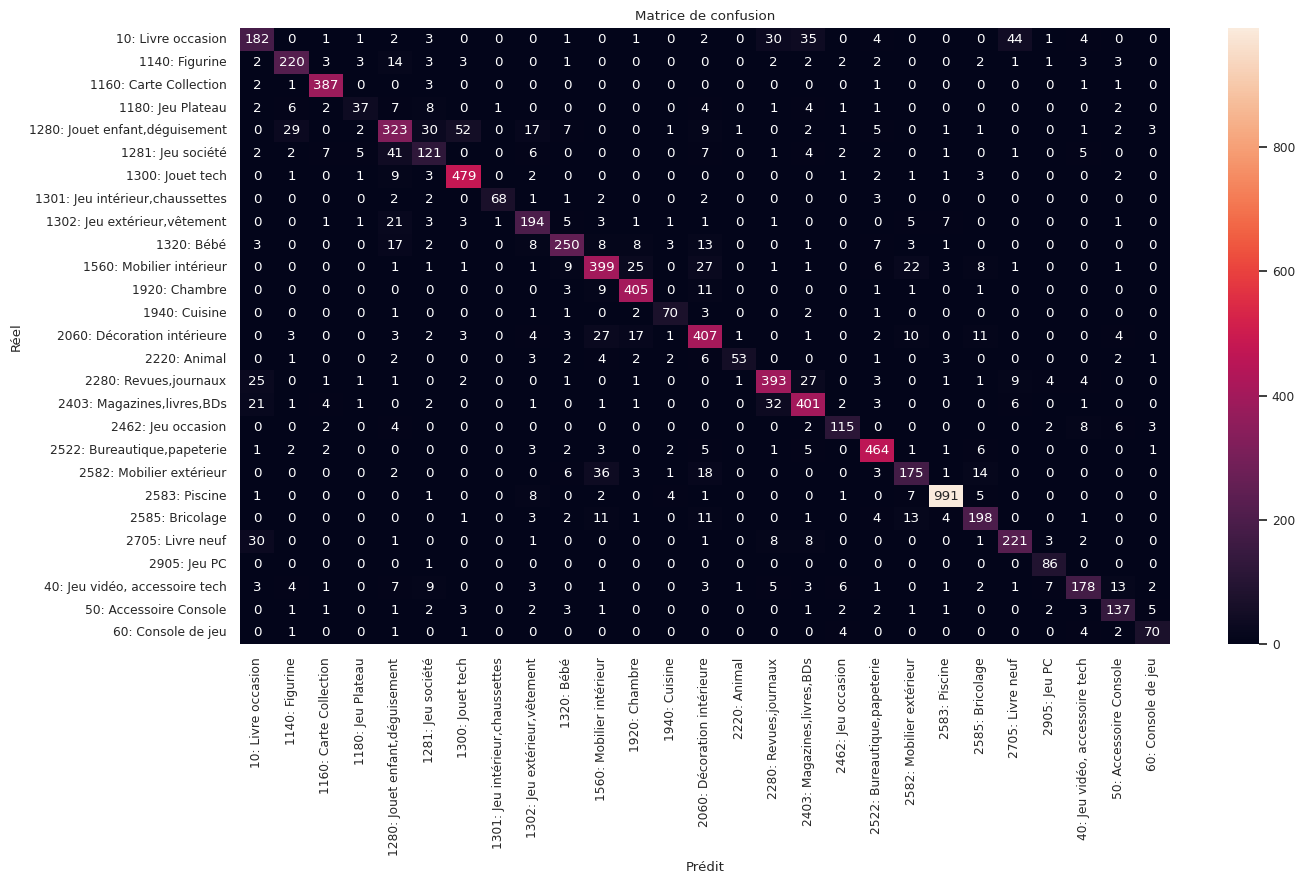

In [43]:
cm = pd.crosstab(y_test.astype("str"),test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))

todo: comment

## Résumé

Nous avons atteint la fin de l'évaluation de cette modélisation. Affichons le rapport du modèle.

In [44]:
reporting_df.loc[model_id].T

model_name                                                   Modèle 4.1.1
dataset_source          output/data-preprocessing-text-stopWord-stemin...
dataset_resampled                                                    True
image_dataset_source      output/data-preprocessing-images/images_pre.zip
image_dataset_zoomed                                                 True
test_size                                                          8491.0
image_model_name                                              Model 3.3.1
image_model_id                                                        331
image_model_path            output/data-modeling-images-3/model-331.keras
text_model_name                                            Model 1.10 svm
text_model_id                                                    1.10 svm
text_model_path         output/data-modeling-text-1bis/model_10_svm.jo...
fusion_model                              VotingClassifier(voting='soft')
image_model_weight                    

todo: comment

# Modélisation 1.2

Ce nouveau réitère le test précédent mais en modifiant cette fois les poids des différents modèles:

- Pour le modèle de texte, on met un poids de 0.6
- Pour le modèle d'image, on en met un de 0.4


In [45]:
model_id = 412

## Initialisation du rapport de modèle

Si un fichier **model_reporting.csv** existe, on le charge. Autrement, on en crée un nouveau.


In [46]:
Path(output_dir).mkdir(parents=True, exist_ok=True)
try:
  reporting_df = load_reporting_df()
  print("loaded ",output_dir+"/model_reporting.csv")
except FileNotFoundError:
  reporting_df = create_reporting_df()
  print(output_dir+"/model_reporting.csv","not found. creating one")


loaded  output/data-modeling-fusion/model_reporting.csv


In [47]:
reporting_df.head()

,model_name,dataset_source,dataset_resampled,image_dataset_source,image_dataset_zoomed,test_size,image_model_name,image_model_id,image_model_path,text_model_name,text_model_id,text_model_path,fusion_model,image_model_weight,text_model_weight,test_f1_score,test_accuracy,remarks
model_id,,,,,,,,,,,,,,,,,,
0,Example model,output/data-exploration/X_train_pre.csv,False,data/images.zip,False,42458.0,Model 3.4.3,343,output/data-modeling-images-3/model-331.keras,Model 1.10,110,output/data-modeling-text-1bis/model_10_svm.jo...,VotingClassifier(voting='soft'),0.5,0.5,0.420000,0.570000,Ceci n'est pas un vrai modèle. C'est juste un ...
411,Modèle 4.1.1,output/data-preprocessing-text-stopWord-stemin...,True,output/data-preprocessing-images/images_pre.zip,True,8491.0,Model 3.3.1,331,output/data-modeling-images-3/model-331.keras,Model 1.10 svm,1.10 svm,output/data-modeling-text-1bis/model_10_svm.jo...,VotingClassifier(voting='soft'),0.5,0.5,0.825214,0.827229,NaN


Ajoutons une ligne correspondant à notre modèle


In [48]:
add_reporting_line(model_id,"Modèle 4.1.2")

## Import des données

On réutilise les données importées précédemment

On peut déjà renseigner les informations sur les données sources qu'on utilise.


In [49]:

update_reporting_line(model_id,{
    "dataset_source": "output/data-preprocessing-text-stopWord-steming/X_test_trad.csv",
    "dataset_resampled": True,
    "image_dataset_source" : "output/data-preprocessing-images/images_pre.zip",
    "image_dataset_zoomed" : True,
})

## Preprocessing

On réutilise le preprocessing de la section précédente

Complétons le rapport avec la taille de jeu de données de test utilisé

In [50]:
update_reporting_line(model_id,{
    "test_size": len(X_test),
})

## Chargement des modèles

On réutililise les modèles chargés dans la dernière section.

In [51]:
update_reporting_line(model_id,{
    "image_model_name": "Model 3.3.1",
    "image_model_id": "331",
    "image_model_path": "output/data-modeling-images-3/model-331.keras",
})
model_image.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [52]:
update_reporting_line(model_id,{
    "text_model_name": "Model 1.10 svm",
    "text_model_id": "1.10 svm",
    "text_model_path": "output/data-modeling-text-1bis/model_10_svm.joblib",
})

## Évaluation du modèle

En nous servant des predictions des modèles d'image de de texte calculés dans la section précédente, on peut reclaculer les prédictions d'ensemble en appliquant cette fois les poids determinés dans le préambule de la section

In [53]:
img_pred_weight = 0.4
text_pred_weight= 0.6
test_pred = get_average_pred(test_pred_image,test_pred_text,
                             img_pred_weight=img_pred_weight,
                             text_pred_weight=text_pred_weight
)
update_reporting_line(model_id,{
    "fusion_model": "VotingClassifier(voting='soft')",
    "image_model_weight": img_pred_weight,
    "text_model_weight": text_pred_weight,
})


Il ne nous reste plus qu'à convertir les index de classes de **test_pred** en labels en se servant de **classes_ordered**.


In [54]:
test_pred_class = [classes_ordered[c] for c in test_pred]

À partir des classes prédites et des observations réelles, on calcule le score F1 ainsi que l'accuracy de notre modèle, toujours sur le jeu de test.

On enregistre ces informations dans le rapport.


In [55]:
f1_weighted = f1_score(y_test.astype("str"),test_pred_class,average="weighted")
accuracy = accuracy_score(y_test.astype("str"),test_pred_class)
update_reporting_line(model_id,{
    "test_f1_score":f1_weighted,
    "test_accuracy":accuracy
})

print("f1_score on test dataset=%.4f" % f1_weighted)
print("accuracy on test dataset=%.4f" % accuracy)

f1_score on test dataset=0.8328
accuracy on test dataset=0.8348


todo: comment

In [56]:
print(classification_report(y_test.astype("str"),test_pred_class))

pd.DataFrame(
    classification_report(y_test.astype("str"),test_pred_class,output_dict=True)
).transpose().to_csv(output_dir+("/classification-report-%d.csv" % model_id),index=True  )

              precision    recall  f1-score   support

          10       0.63      0.55      0.59       311
        1140       0.80      0.82      0.81       267
        1160       0.94      0.98      0.96       396
        1180       0.76      0.46      0.57        76
        1280       0.70      0.69      0.69       487
        1281       0.66      0.62      0.64       207
        1300       0.89      0.96      0.92       505
        1301       0.99      0.88      0.93        81
        1302       0.80      0.79      0.79       249
        1320       0.87      0.80      0.83       324
        1560       0.79      0.82      0.81       507
        1920       0.88      0.94      0.91       431
        1940       0.88      0.86      0.87        81
        2060       0.78      0.83      0.80       499
        2220       0.96      0.67      0.79        82
        2280       0.78      0.83      0.81       475
        2403       0.81      0.83      0.82       477
        2462       0.87    

todo: comment

Affichons la matrice de confusion sous forme de heatmap pour plus de lisibilité.

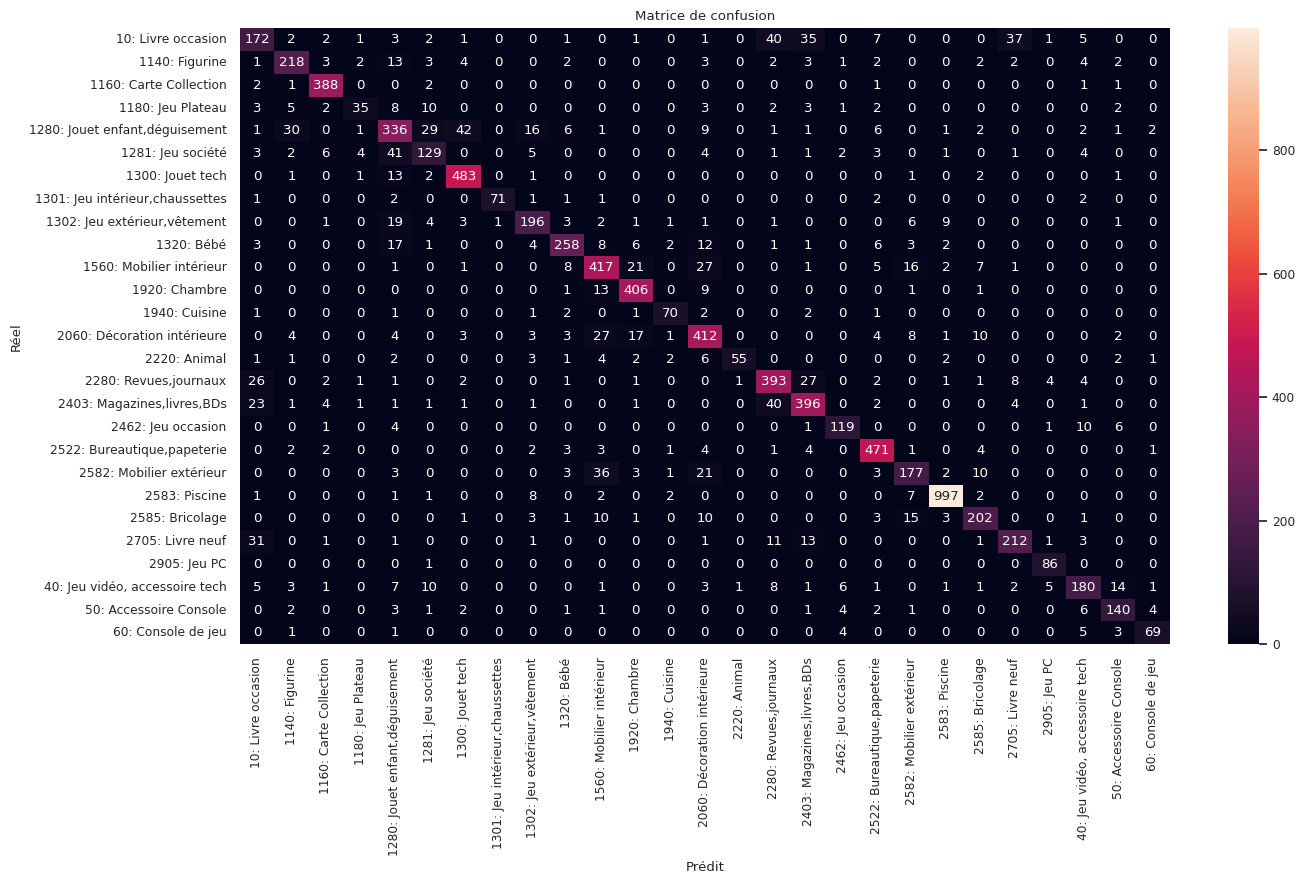

In [57]:
cm = pd.crosstab(y_test.astype("str"),test_pred_class,rownames=["réel"],colnames=["prédit"])
plot_confusion_matrix(np.array(cm))

todo: comment

## Résumé

Nous avons atteint la fin de l'évaluation de cette modélisation. Affichons le rapport du modèle.

In [58]:
reporting_df.loc[model_id].T

model_name                                                   Modèle 4.1.2
dataset_source          output/data-preprocessing-text-stopWord-stemin...
dataset_resampled                                                    True
image_dataset_source      output/data-preprocessing-images/images_pre.zip
image_dataset_zoomed                                                 True
test_size                                                          8491.0
image_model_name                                              Model 3.3.1
image_model_id                                                        331
image_model_path            output/data-modeling-images-3/model-331.keras
text_model_name                                            Model 1.10 svm
text_model_id                                                    1.10 svm
text_model_path         output/data-modeling-text-1bis/model_10_svm.jo...
fusion_model                              VotingClassifier(voting='soft')
image_model_weight                    

# Comparaison de tous les modèles de fusion

Comparons maintenant tous les modèles du notebooks.

In [59]:
model_comparison_cols = ["model_name","fusion_model","image_model_weight","text_model_weight",
                         "image_model_id","text_model_id",
                         "dataset_resampled","image_dataset_zoomed",
                      "test_size",
                      "test_f1_score","test_accuracy"]
display(reporting_df.loc[[411,412],model_comparison_cols].T)

model_id,411,412
model_name,Modèle 4.1.1,Modèle 4.1.2
fusion_model,VotingClassifier(voting='soft'),VotingClassifier(voting='soft')
image_model_weight,0.5,0.4
text_model_weight,0.5,0.6
image_model_id,331.0,331
text_model_id,1.10 svm,1.10 svm
dataset_resampled,True,True
image_dataset_zoomed,True,True
test_size,8491.0,8491.0
test_f1_score,0.825214,0.832794


# Conclusion

todo: comment